<div class="alert alert-block alert-info">
<b>Import libraries $\&$ initialize variables </b>
</div>

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

In [2]:
# Initialize thresholds, directories, and methods
tau_list = [0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
npz_dir = "./npz_data/" 
data_dir = "./monitors_data/"  
img_dir = "./images/" 

os.makedirs(img_dir, exist_ok=True)

# Fetch dataset names and clean them
datasets_names = os.listdir(data_dir)
datasets = [name.split('.')[0] for name in datasets_names]

# Initialize array for ATFP (Assumed to be 6 columns)
num_rows = len(datasets) * len(tau_list)
arr_ATFP = np.zeros((num_rows, 6), dtype=object)

methods = ["deepgini", "entropy"]

<div class="alert alert-block alert-info">
<b>Effectiveness Evaluation:</b> DeepGini, Entropy, DeepAbstraction
</div>

In [3]:
row = 0

# Function to calculate TPF 
def calculate_TPF(df, no_buggy_instances):
    tpf_list = []
    for k in range(no_buggy_instances):
        bdgt = k + 1
        TPF = sum(df.iloc[:bdgt, 0] != df.iloc[:bdgt, 1]) / bdgt
        tpf_list.append(TPF)
    return tpf_list

# Loop through each dataset
for dataset in datasets:
    df = pd.read_excel(f'{data_dir}{dataset}.xlsx', sheet_name=0)
    no_buggy_instances = (df['Ground Truth'] != df['Predicted class']).sum()

    # DeepGini
    df.sort_values(by=['deepgini'], ascending=False, inplace=True)
    gini = calculate_TPF(df, no_buggy_instances)
    
    # Entropy
    df.sort_values(by=['entropy'], ascending=False, inplace=True)
    entropy = calculate_TPF(df, no_buggy_instances)

    # DeepAbstraction  
    for tau in tau_list:     
        for method in methods:
            dfs_by_verdict = [df[df[f'verdict_{tau}'] == verdict] for verdict in [1, 2, 0]]
            dfs_sorted = [df.sort_values(by=[method], ascending=False) for df in dfs_by_verdict]
            df_monitor = pd.concat(dfs_sorted)
            df_monitor = df_monitor[df_monitor[method] > 0]
            tpf_monitor = calculate_TPF(df_monitor, no_buggy_instances)
            
            # Update arr_ATFP
            arr_ATFP[row, :4] = [dataset, tau, round(100 * sum(gini) / no_buggy_instances, 2), 
                                 round(100 * sum(entropy) / no_buggy_instances, 2)]
            arr_ATFP[row, 4 + methods.index(method)] = round(100 * sum(tpf_monitor) / no_buggy_instances, 2)
            
        row += 1

    print(f"All TP techniques have been evaluated successfully on {dataset}")

All TP techniques have been evaluated successfully on CIFAR10 - GoogleNet
All TP techniques have been evaluated successfully on CIFAR10 - ResNet101
All TP techniques have been evaluated successfully on CIFAR10 - ResNet18
All TP techniques have been evaluated successfully on FMNIST - ResNet18
All TP techniques have been evaluated successfully on FMNIST - ResNet50
All TP techniques have been evaluated successfully on FMNIST - VGG16
All TP techniques have been evaluated successfully on MNIST - LeNet5
All TP techniques have been evaluated successfully on MNIST - ResNet18
All TP techniques have been evaluated successfully on SVHN - AlexNet
All TP techniques have been evaluated successfully on SVHN - ResNet18


In [4]:
final_df = pd.DataFrame(arr_ATFP, columns=['dataset', 'tau', 'DeepGini', 'Entropy', 'DeepAbstr_gini', 'DeepAbstr_entropy'])
final_df.set_index('dataset', inplace=True)
output_file_name = "overall_performance.xlsx"
final_df.to_excel(output_file_name, index=True)
final_df.reset_index(inplace=True)
final_df.head(6)

dataset   tau DeepGini Entropy DeepAbstr_gini DeepAbstr_entropy
0  CIFAR10 - GoogleNet   0.4    57.17   55.04          75.33             74.53
1  CIFAR10 - GoogleNet   0.3    57.17   55.04          76.02             75.26
2  CIFAR10 - GoogleNet   0.2    57.17   55.04          77.57             77.13
3  CIFAR10 - GoogleNet   0.1    57.17   55.04          77.65             77.22
4  CIFAR10 - GoogleNet  0.05    57.17   55.04          79.12             78.99
5  CIFAR10 - GoogleNet  0.01    57.17   55.04          75.07             75.68

In [5]:
# The best tau for each dataset
final_df['DeepAbstr_gini'] = pd.to_numeric(final_df['DeepAbstr_gini'])
max_apfl = final_df.groupby('dataset')['DeepAbstr_gini'].transform('max') == final_df['DeepAbstr_gini']
best_tau_df = final_df.loc[max_apfl,['dataset','tau']]
best_tau_df.reset_index(inplace=True, drop=True)
best_tau_df

dataset   tau
0  CIFAR10 - GoogleNet  0.05
1  CIFAR10 - ResNet101  0.01
2   CIFAR10 - ResNet18  0.05
3    FMNIST - ResNet18  0.05
4    FMNIST - ResNet50  0.05
5       FMNIST - VGG16  0.01
6       MNIST - LeNet5   0.4
7     MNIST - ResNet18   0.3
8       SVHN - AlexNet  0.01
9      SVHN - ResNet18  0.05

<div class="alert alert-block alert-info">
<b>Effectiveness Evaluation: </b>
 <ul>
  <li>removing zero-scored instances</li>
  <li> misclassified instances per region type</li>
</ul>
</div>

<div class="alert alert-block alert-warning">
<b>Removing zero-scored instances</b>
</div>

In [6]:
# Initialize arrays for storing dataset-specific information
arr_miss = np.zeros((len(datasets), 7), dtype=object)
arr_zero_remov = np.zeros((len(datasets) * 2, 4), dtype=object)

# Function to update array for zero-scored instances
def update_zero_remov_array(arr, idx, dataset, state, df, verdict, j):
    query_string = f'(`Ground Truth` != `Predicted class`) and (`verdict_{j}` == {verdict})'
    arr[idx, 0] = dataset
    arr[idx, 1] = state
    arr[idx, 2] = df.query(query_string).shape[0]
    arr[idx, 3] = df.query(query_string.replace('!=', '==')).shape[0]

for i, dataset in enumerate(datasets):

    df = pd.read_excel(f'{data_dir}{dataset}.xlsx', sheet_name=0)
    no_buggy_instances = (df['Ground Truth'] != df['Predicted class']).sum().tolist()

    # DeepGini
    df.sort_values(by=['deepgini'], ascending=False, inplace=True)
    gini_df = df.head(no_buggy_instances)

    # Get the best tau value for the current dataset
    j = best_tau_df.loc[best_tau_df['dataset'] == dataset, 'tau'].values[0]

    # Create dataframes based on verdicts
    dfs_by_verdict = [df[df[f'verdict_{j}'] == verdict] for verdict in [1, 2, 0]]
    dfs_sorted = [df.sort_values(by=['deepgini'], ascending=False) for df in dfs_by_verdict]
    df_monitor = pd.concat(dfs_sorted)
    df_monitor = df_monitor[df_monitor['deepgini'] > 0]
    monitor_df = df_monitor.head(no_buggy_instances)

    # Update arr_zero_remov
    update_zero_remov_array(arr_zero_remov, i * 2, dataset, "before", df, 1, j)
    update_zero_remov_array(arr_zero_remov, i * 2 + 1, dataset, "after", df_monitor, 1, j)

    # Update arr_miss
    arr_miss[i, 0] = dataset
    arr_miss[i, 1:4] = [
        df.query('0.7 <= distance_ratio <= 1.3').shape[0],
        monitor_df.query('0.7 <= distance_ratio <= 1.3').shape[0],
        gini_df.query('0.7 <= distance_ratio <= 1.3').shape[0]
    ]
    arr_miss[i, 4:] = [
        df.query('(0.0 < distance_ratio <= 0.7) or (distance_ratio > 1.3)').shape[0],
        monitor_df.query('(0.0 < distance_ratio <= 0.7) or (distance_ratio > 1.3)').shape[0],
        gini_df.query('(0.0 < distance_ratio <= 0.7) or (distance_ratio > 1.3)').shape[0]
    ]
    print(f"Zero-scored instances removal in {dataset} has been analyzed successfully!")


Zero-scored instances removal in CIFAR10 - GoogleNet has been analyzed successfully!
Zero-scored instances removal in CIFAR10 - ResNet101 has been analyzed successfully!
Zero-scored instances removal in CIFAR10 - ResNet18 has been analyzed successfully!
Zero-scored instances removal in FMNIST - ResNet18 has been analyzed successfully!
Zero-scored instances removal in FMNIST - ResNet50 has been analyzed successfully!
Zero-scored instances removal in FMNIST - VGG16 has been analyzed successfully!
Zero-scored instances removal in MNIST - LeNet5 has been analyzed successfully!
Zero-scored instances removal in MNIST - ResNet18 has been analyzed successfully!
Zero-scored instances removal in SVHN - AlexNet has been analyzed successfully!
Zero-scored instances removal in SVHN - ResNet18 has been analyzed successfully!


In [7]:
# Create DataFrame from arr_zero_remov and display first 20 rows
zero_removal_df = pd.DataFrame(
    arr_zero_remov, columns=['dataset', 'when', 'TP', 'FP']
)

zero_removal_df.head(20)

dataset    when   TP   FP
0   CIFAR10 - GoogleNet  before  385  111
1   CIFAR10 - GoogleNet   after  377   79
2   CIFAR10 - ResNet101  before  752  450
3   CIFAR10 - ResNet101   after  746  275
4    CIFAR10 - ResNet18  before  769  150
5    CIFAR10 - ResNet18   after  734   79
6     FMNIST - ResNet18  before  305  236
7     FMNIST - ResNet18   after  301   48
8     FMNIST - ResNet50  before  639  320
9     FMNIST - ResNet50   after  639  111
10       FMNIST - VGG16  before  412   26
11       FMNIST - VGG16   after  408   24
12       MNIST - LeNet5  before   82   39
13       MNIST - LeNet5   after   82   32
14     MNIST - ResNet18  before   52  130
15     MNIST - ResNet18   after   50   13
16       SVHN - AlexNet  before  612   59
17       SVHN - AlexNet   after  567   19
18      SVHN - ResNet18  before  662  119
19      SVHN - ResNet18   after  641   89

In [8]:
condition = zero_removal_df['dataset'].str.contains('ResNet18')

# Melt the DataFrame to a long format suitable for plotting
new_df = zero_removal_df.loc[condition, ['dataset', 'when', 'TP', 'FP']]\
                        .melt(
                              id_vars=['dataset', 'when'],
                              var_name='type',
                              value_name='value'
                             )


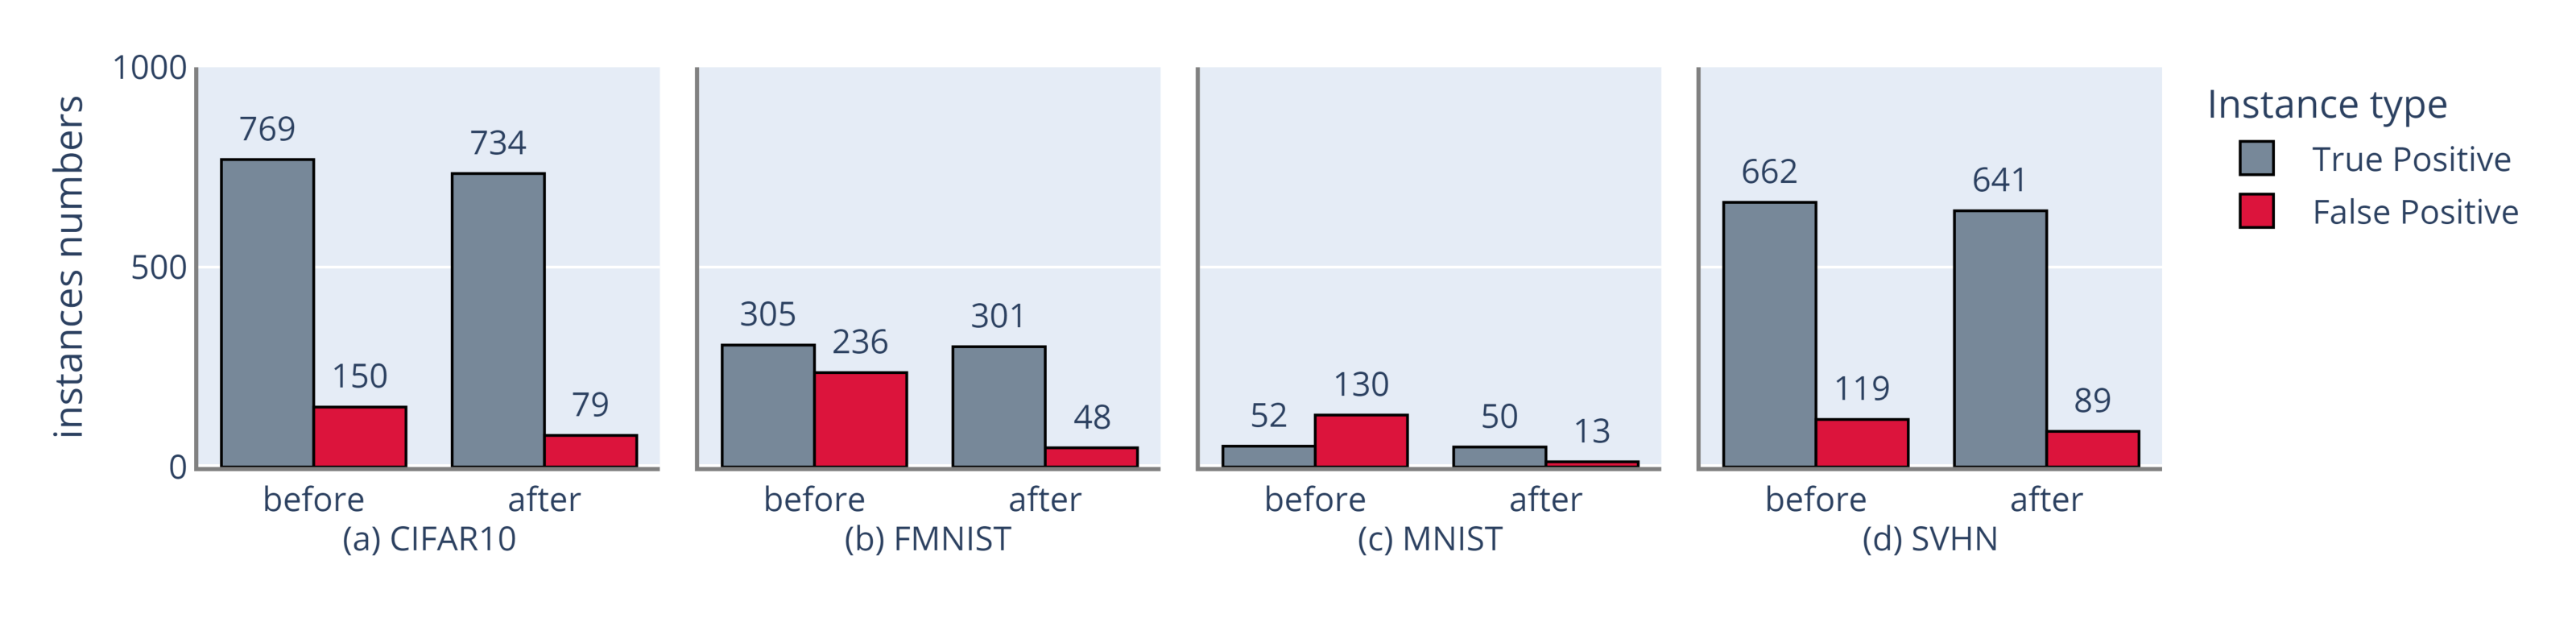

In [9]:
# Create a bar chart using Plotly
fig = px.bar(
    new_df, x='when', y='value', facet_col='dataset', 
    facet_col_spacing=0.02, color='type',
    labels={'when': '', 'value': 'instances numbers', 'type': 'Instance type'},
    height=300, barmode='group', text_auto=True,
    color_discrete_sequence=['lightslategray', 'crimson']
)

# Update marker line properties
for i in range(len(fig.data)):
    fig.data[i].marker.line.width = 1
    fig.data[i].marker.line.color = 'black'

# Update legend labels
newnames = {'TP': 'True Positive', 'FP': 'False Positive'}
fig.for_each_trace(
    lambda t: t.update(name=newnames[t.name], legendgroup='instances type', textposition='outside')
)

# Update axis properties
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='gray', mirror=False)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='gray', mirror=False, range=[0, 1000])

# Add custom annotations
text_lst = ['(a) CIFAR10', '(b) FMNIST', '(c) MNIST', '(d) SVHN']
for i in range(len(text_lst)):
    fig['layout']['annotations'][i]['text'] = text_lst[i]
    fig['layout']['annotations'][i]['y'] = -0.25

# Save the figure
fig.update_layout(width=900, height=200, margin=dict(l=1, r=1, t=2, b=2))
pio.write_image(fig, f'{img_dir}zero_remove_effect.png', scale=6)

# Uncomment to display the figure in notebook
# fig.show("notebook")
figure(figsize=(8, 10), dpi=500)
image = plt.imread(f'{img_dir}zero_remove_effect.png')
plt.axis('off')
plt.imshow(image);

<div class="alert alert-block alert-warning">
<b>Misclassified instances per region type</b>
</div>

In [10]:
# Create a DataFrame from arr_miss and display it
position_df = pd.DataFrame(
    arr_miss, 
    columns=[
        'dataset', 'total-boundary', 'Monitor-boundary', 'DeepGini-boundary',
        'total-centroid', 'Monitor-centroid', 'DeepGini-centroid'
    ]
)
position_df

dataset total-boundary Monitor-boundary DeepGini-boundary  \
0  CIFAR10 - GoogleNet           9733              695               832   
1  CIFAR10 - ResNet101           9569             1179              1347   
2   CIFAR10 - ResNet18           9560             1118              1344   
3    FMNIST - ResNet18           9725              570               681   
4    FMNIST - ResNet50           9338              863              1081   
5       FMNIST - VGG16           9585              563               674   
6       MNIST - LeNet5           9948               86               125   
7     MNIST - ResNet18           9974               41                51   
8       SVHN - AlexNet          25588             1483              1592   
9      SVHN - ResNet18          25627              820              1115   

  total-centroid Monitor-centroid DeepGini-centroid  
0            268              202                65  
1            431              318               150  
2            441              339               113  
3            275              183                72  
4            662              430               212  
5            415              302               191  
6             52               44                 5  
7             26               16                 6  
8            444              280               171  
9            405              345                50

<div class="alert alert-block alert-info">
    <b>Stability Evaluation:</b> DeepAbstraction with different scoring functions
</div>

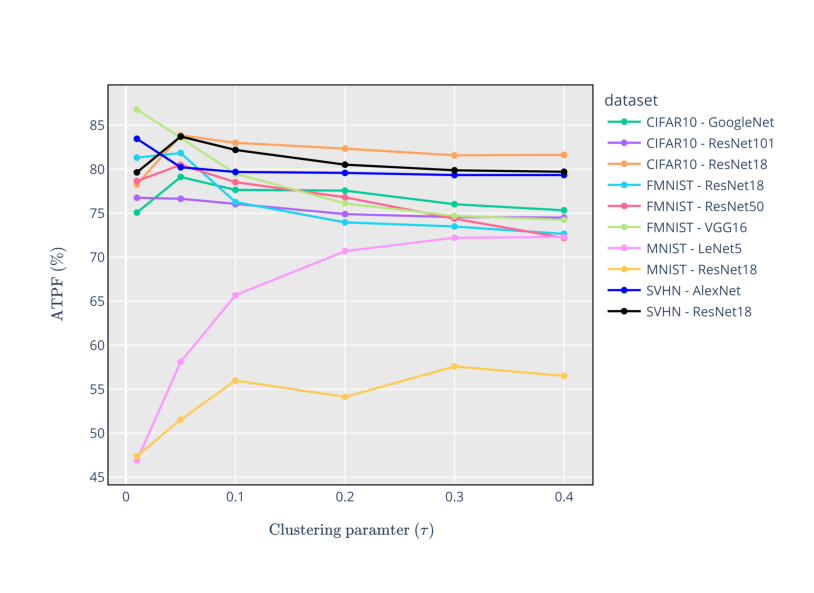

In [11]:
# Define color mapping for line chart
color_discrete_map = {'SVHN - ResNet18': 'black', 'SVHN - AlexNet': 'blue'}

# Create line chart using Plotly
fig = px.line(
    final_df, x='tau', y='DeepAbstr_gini', color='dataset',
    color_discrete_map=color_discrete_map, markers=True
)

# Update layout properties
fig.update_layout(
    plot_bgcolor='rgb(233,233,233)',
    yaxis_title=r'$\text{ATPF } (\%)$',
    xaxis_title=r'$\text{Clustering paramter }(\tau)$',
    showlegend=True
)

# Update axis line properties
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Save the figure to an image file
pio.write_image(fig, f'{img_dir}DA_gini.png', scale=6)

# Uncomment to display the figure in notebook (alternative method)
#fig.show("notebook")
figure(figsize=(5, 5), dpi=200)
image = plt.imread(f'{img_dir}DA_gini.png')
plt.axis('off')
plt.imshow(image)


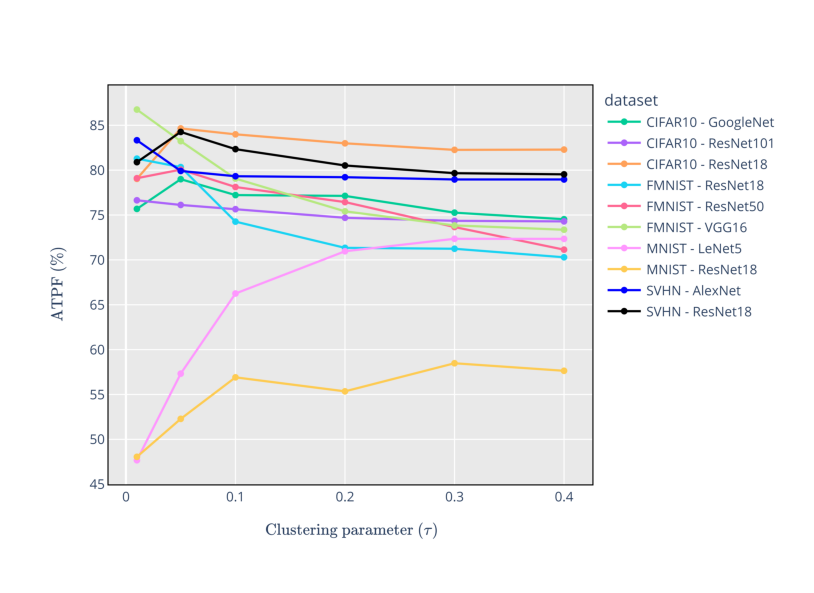

In [12]:
# Define color mapping for line chart
color_discrete_map = {'SVHN - ResNet18': 'black', 'SVHN - AlexNet': 'blue'}

# Create a line chart using Plotly
fig = px.line(
    final_df, x='tau', y='DeepAbstr_entropy', color='dataset',
    color_discrete_map=color_discrete_map, markers=True
)

# Update layout properties
fig.update_layout(
    plot_bgcolor='rgb(233, 233, 233)',
    yaxis_title=r'$\text{ATPF } (\%)$',
    xaxis_title=r'$\text{Clustering parameter }(\tau)$',
    showlegend=True
)

# Update axis line properties
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Save the figure as an image file
pio.write_image(fig, f'{img_dir}DA_entropy.png', scale=6)

# Uncomment the following lines if running the Jupyter notebook on your device
# fig.show("notebook")
figure(figsize=(5, 5), dpi=200)
image = plt.imread(f'{img_dir}DA_entropy.png')
plt.axis('off')
plt.imshow(image)